In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
customers = pd.read_csv("customers.csv")
products = pd.read_csv("products.csv")
transactions = pd.read_csv("transactions.csv")

In [3]:
# Step 1: Merge datasets
# Merge transactions with products
transactions_products = pd.merge(transactions, products, on="ProductID", how="left")

In [4]:
# Merge the result with customers
full_data = pd.merge(transactions_products, customers, on="CustomerID", how="left")

In [5]:
# Step 2: Feature Engineering
# Extract features for clustering
# - Total transaction value per customer
total_value = full_data.groupby("CustomerID")["TotalValue"].sum().rename("TotalTransactionValue")

In [6]:
# - Total quantity purchased per customer
total_quantity = full_data.groupby("CustomerID")["Quantity"].sum().rename("TotalQuantity")


In [7]:
# - Region (encode as one-hot)
region_dummies = pd.get_dummies(customers["Region"], prefix="Region")


In [8]:
# - Days since signup
customers["SignupDate"] = pd.to_datetime(customers["SignupDate"])
days_since_signup = (pd.Timestamp.now() - customers["SignupDate"]).dt.days.rename("DaysSinceSignup")

In [9]:
# Combine features
customer_features = pd.concat([total_value, total_quantity], axis=1).reset_index()
customer_features = customer_features.merge(customers[["CustomerID"]], on="CustomerID", how="left")
customer_features = pd.concat([customer_features, region_dummies], axis=1)
customer_features["DaysSinceSignup"] = days_since_signup


In [10]:
# Fill missing values with 0 (for customers with no transactions)
customer_features.fillna(0, inplace=True)

In [11]:
# Step 3: Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features.drop(columns=["CustomerID"]))

In [12]:
# Step 4: Clustering
# Test different numbers of clusters (2–10) and evaluate DB Index
db_scores = []
silhouette_scores = []
cluster_range = range(2, 11)

In [13]:
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)

    clusters = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, clusters)
    silhouette_avg = silhouette_score(scaled_features, clusters)
    db_scores.append(db_index)
    silhouette_scores.append(silhouette_avg)

In [14]:
# Select optimal number of clusters based on DB Index
optimal_clusters = cluster_range[np.argmin(db_scores)]

In [15]:
# Fit KMeans with optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
final_clusters = kmeans.fit_predict(scaled_features)
customer_features["Cluster"] = final_clusters

In [16]:
# Step 5: Visualization
# Reduce dimensions to 2 using PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
customer_features["PCA1"] = pca_features[:, 0]
customer_features["PCA2"] = pca_features[:, 1]

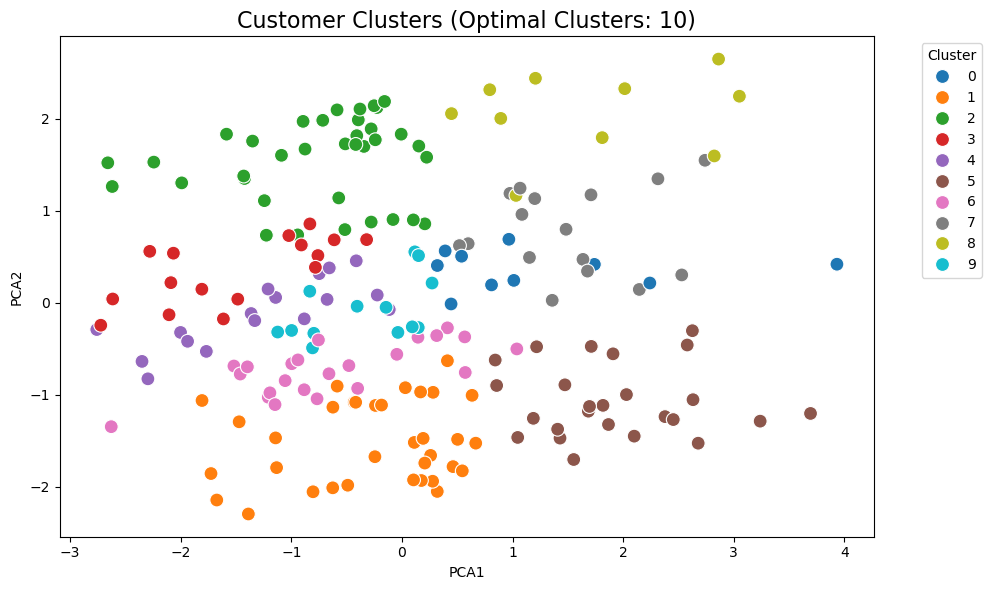

In [17]:
# Scatter plot of clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="PCA1", y="PCA2", hue="Cluster", data=customer_features, palette="tab10", s=100
)
plt.title(f"Customer Clusters (Optimal Clusters: {optimal_clusters})", fontsize=16)
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [18]:
# Step 6: Evaluation Report
print(f"Optimal Number of Clusters: {optimal_clusters}")
print(f"DB Index for Optimal Clusters: {min(db_scores):.4f}")
print(f"Silhouette Score for Optimal Clusters: {max(silhouette_scores):.4f}")

Optimal Number of Clusters: 10
DB Index for Optimal Clusters: 0.9140
Silhouette Score for Optimal Clusters: 0.4506


In [19]:
# Save clustering results
customer_features.to_csv("ClusteringResults.csv", index=False)
print("Clustering results saved to 'ClusteringResults.csv'.")

Clustering results saved to 'ClusteringResults.csv'.
